# autograd：自动求导系统

在深度学习中，权值的更新是依赖于梯度的计算，因此梯度的计算是至关重要的。在 PyTorch 中，只需要搭建好前向计算图，然后利用`torch.autograd`自动求导得到所有张量的梯度。

## torch.autograd.backward()
`torch.autograd.backward(tensors, grad_tensors=None, retain_graph=None, create_graph=False, grad_variables=None)`  
功能：自动求取梯度  
* tensors：用于求导的张量，如loss
* retain_graph：保存计算图。PyTorch 采用动态图机制，默认每次反向传播之后都会释放计算图。这里设置为 True 可以不释放计算图。
* create_graph：创建导数计算图，用于高阶求导
* grad_tensors：多梯度权重，当有多个 loss 混合需要计算梯度时，设置每个 loss 的权重。

### retain_graph 参数

<img src="img/计算图与梯度求导.png" width="300">

$$\begin{aligned} 
\frac{\partial y}{\partial w} &=\frac{\partial y}{\partial a} \frac{\partial a}{\partial w}+\frac{\partial y}{\partial b} \frac{\partial b}{\partial w} \\ 
&=b \times 1+a \times 1 \\ 
&=(w+1)+(x+w) \\ 
&=2  w+x+1 
\end{aligned}$$

In [1]:
import torch

x = torch.tensor([2.],requires_grad=True)
w = torch.tensor([1.],requires_grad=True)
a = x+w
b = w+1
y = a*b

y.backward()    # 实际调用的就是torch.autograd.backward()
print(w.grad)

tensor([5.])


In [2]:
y.backward()

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

其中`y.backward()`方法调用的是`torch.autograd.backward(self, gradient, retain_graph, create_graph)`。  

但是在第二次执行`y.backward()`时会出错。因为 PyTorch 默认是每次求取梯度之后不保存计算图的，因此第二次求导梯度时，计算图已经不存在了。在第一次求梯度时使用`y.backward(retain_graph=True)`即可。

In [3]:
x = torch.tensor([2.],requires_grad=True)
w = torch.tensor([1.],requires_grad=True)
a = x+w
b = w+1
y = a*b

y.backward(retain_graph=True)
y.backward()
print(w.grad)

tensor([10.])


### grad_tensors 参数

In [4]:
x = torch.tensor([2.],requires_grad=True)
w = torch.tensor([1.],requires_grad=True)
a = x+w
b = w+1
y0 = a*b
y1 = a+b   # dy1/dw = 2

loss = torch.cat([y0,y1])               # 把两个 loss 拼接都到一起
grad_tensors = torch.tensor([1,2])      # 设置两个 loss 的权重: y0 的权重是 1，y1 的权重是 2

loss.backward(gradient=grad_tensors)    # gradient 传入 torch.autograd.backward()中的 grad_tensors
print(w.grad)                                # 最终的 w 的导数由两部分组成。∂y0/∂w * 1 + ∂y1/∂w * 2

tensor([9.])


该 loss 由两部分组成：$y_0$ 和 $y_1$。其中 $\frac{\partial y_0}{\partial w}=5$，$\frac{\partial y_1}{\partial w}=2$。而 gradtensors 设置两个 loss 对 w 的权重分别为 $1$ 和 $2$。因此最终 w 的梯度为：$\frac{\partial y_0}{\partial w} \times 1+ \frac{\partial y_1}{\partial w} \times 2=9$。

## torch.autograd.grad()
`torch.autograd.grad(outputs, inputs, grad_outputs=None, retain_graph=None, create_graph=False, only_inputs=True, allow_unused=False)`  
功能：求取梯度。  
* outputs: 用于求导的张量，如 loss
* inputs: 需要梯度的张量
* create_graph: 创建导数计算图，用于高阶求导
* retain_graph:保存计算图
* grad_outputs: 多梯度权重计算  

`torch.autograd.grad()`的返回结果是一个`tunple`，需要取出第 0 个元素才是真正的梯度。

In [5]:
x = torch.tensor([3.],requires_grad=True)
y = torch.pow(x,2)      # y=x^2

# 求一阶导数，create_graph=True创建一阶导数的计算图，才能计算二阶导数
grad_1 = torch.autograd.grad(outputs=y,inputs=x,create_graph=True)
print(grad_1)
# 求二阶导数
grad_2 = torch.autograd.grad(outputs=grad_1[0],inputs=x)
print(grad_2)

(tensor([6.], grad_fn=<MulBackward0>),)
(tensor([2.]),)


## 注意事项
1. 在每次反向传播求导时，计算的梯度不会自动清零。如果进行多次迭代计算梯度而没有清零，那么梯度会在前一次的基础上叠加。

In [6]:
x = torch.tensor([2.],requires_grad=True)
w = torch.tensor([1.],requires_grad=True)

for i in range(2):
    a = x+w
    b = w+1
    y = a*b
    y.backward()
    print(w.grad)

tensor([5.])
tensor([10.])


In [7]:
x = torch.tensor([2.],requires_grad=True)
w = torch.tensor([1.],requires_grad=True)

for i in range(2):
    a = x+w
    b = w+1
    y = a*b
    y.backward()
    print(w.grad)
    w.grad.zero_()   # 将梯度清零

tensor([5.])
tensor([5.])


2. 依赖于叶子节点的节点，requires_grad 属性默认为 True。

In [8]:
x = torch.tensor([2.],requires_grad=True)
w = torch.tensor([1.],requires_grad=True)
a = x+w
b = w+1
y = a*b

print(a.requires_grad,b.requires_grad,y.requires_grad)

True True True


3. 叶子节点不可执行 inplace 操作。  

以加法来说，inplace 操作有`a += x`，`a.add_(x)`，改变后的值和原来的值内存地址是同一个。非inplace 操作有`a = a + x`，`a.add(x)`，改变后的值和原来的值内存地址不是同一个。  

这是因为在进行前向传播时，计算图中依赖于叶子节点的那些节点，会记录叶子节点的地址，在反向传播时就会利用叶子节点的地址所记录的值来计算梯度。比如在 $y=a \times b$ ，其中 $a=x+w$，$b=w+1$，$x$ 和 $w$ 是叶子节点。当求导 $\frac{\partial y}{\partial a} = b = w+1$，需要用到叶子节点 $w$。

In [9]:
x = torch.tensor([2.],requires_grad=True)
w = torch.tensor([1.],requires_grad=True)
a = x+w
b = w+1
y = a*b

w.add_(1)

RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.

# 逻辑回归

逻辑回归是线性的二分类模型。模型表达式：   
$$y=f(z)=\frac{1}{1+e^{-z}}$$

其中 $z=WX+b$，就是原来的线性回归的模型。$f(z)$ 称为 sigmoid 函数，也被称为 Logistic 函数。  
函数曲线如下：(横坐标是 $z$，纵坐标是 $y$)  

<img src="img/逻辑回归.png" width="250">

分类原则如下：
$$y=
\begin{cases}
0, &z<0 \\
0.5, &z=0  \\
1, &z>0
\end{cases}$$

若预测值 $z$ 大于零就判为正例，小于零则判为反例，预测值为临界值零则可以任意判别。

逻辑回归是在线性回归的基础上加入了一个 sigmoid 函数，这是为了更好地描述置信度，把输入映射到 (0,1) 区间中，符合概率取值。  

逻辑回归也被称为对数几率回归 $\ln \frac{y}{1-y}=W X+b$，几率的表达式为：$\frac{y}{1-y}$，$y$ 表示正类别的概率，$1-y$ 表示另一个类别的概率。

## PyTorch 实现逻辑回归

PyTorch 构建模型需要 5 大步骤：
* 数据：包括数据读取，数据清洗，进行数据划分和数据预处理，比如读取图片如何预处理及数据增强。
* 模型：包括构建模型模块，组织复杂网络，初始化网络参数，定义网络层。
* 损失函数：包括创建损失函数，设置损失函数超参数，根据不同任务选择合适的损失函数。
* 优化器：包括根据梯度使用某种优化器更新参数，管理模型参数，管理多个参数组实现不同学习率，调整学习率。
* 迭代训练：组织上面 4 个模块进行反复训练。包括观察训练效果，绘制 Loss/ Accuracy 曲线，用 TensorBoard 进行可视化分析。

In [10]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(10)

In [11]:
# 1.生成数据
sample_nums = 100
mean_value = 1.7
bias = 1
n_data = torch.ones((sample_nums,2))
x0 = torch.normal(mean_value * n_data,1)+bias     # 类别0 数据 shape=(100,2)
x1 = torch.normal(-mean_value * n_data,1)+bias    # 类别1 数据 shape=(100,2)
y0 = torch.zeros(sample_nums)                     # 类别0 标签 shape=(100,1)
y1 = torch.ones(sample_nums)                      # 类别1 标签 shape=(100,1)
train_x = torch.cat([x0,x1],0)
train_y = torch.cat([y0,y1],0)

In [12]:
# 2.选择模型
class LR(nn.Module):
    def __init__(self):
        super(LR, self).__init__()
        self.features = nn.Linear(2,1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        x = self.features(x)
        x = self.sigmoid(x)
        return x
    
lr_net = LR()

In [13]:
# 3.选择损失函数
loss_fn = nn.BCELoss()

In [14]:
# 4.选择优化器
lr = 0.01    # 学习率
optimizer = torch.optim.SGD(lr_net.parameters(),lr=lr,momentum=0.9)      # 随机梯度下降

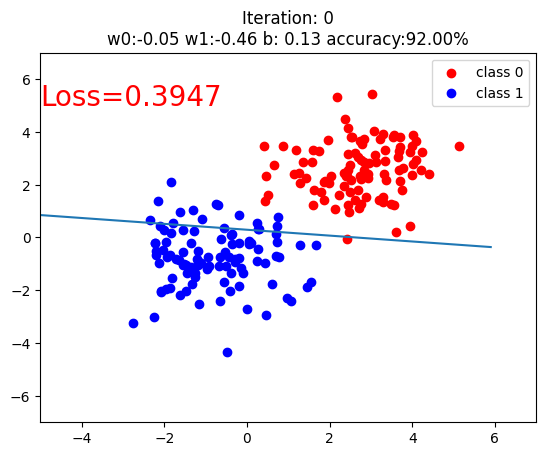

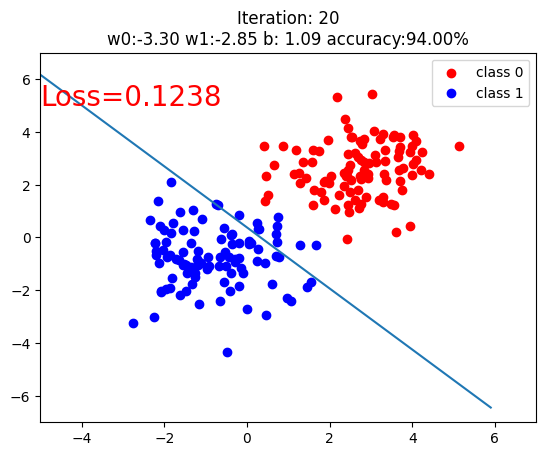

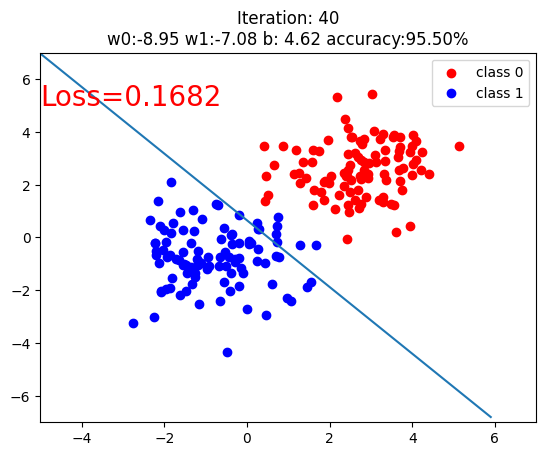

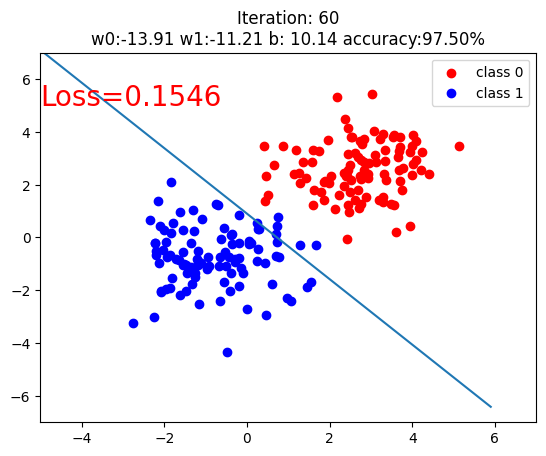

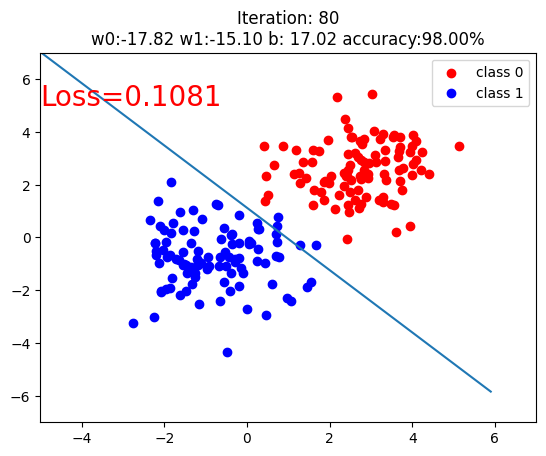

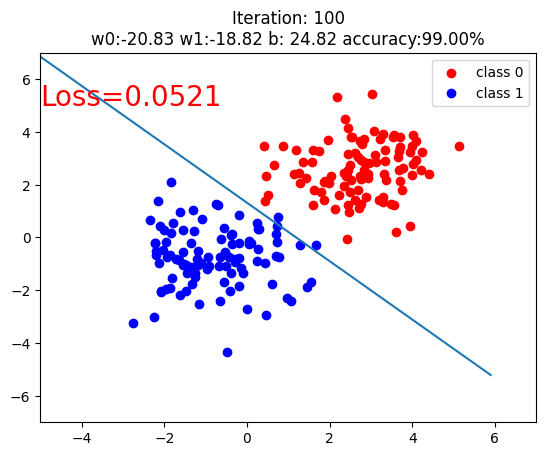

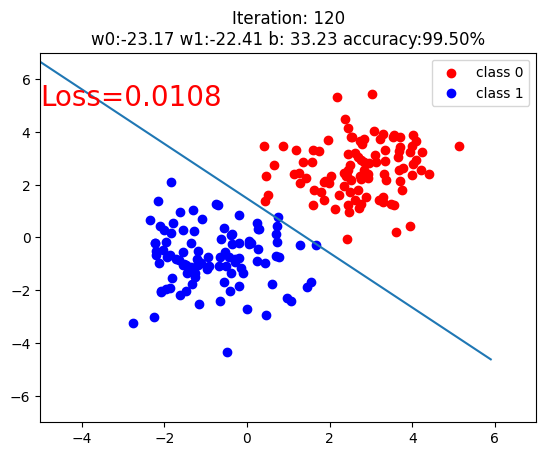

In [15]:
# 5.模型训练
for iteration in range(1000):
    # 前向传播
    y_pred = lr_net(train_x)
    # 计算loss
    loss = loss_fn(y_pred.squeeze(),train_y)
    # 反向传播
    loss.backward()
    # 更新参数
    optimizer.step()
    # 绘图
    if iteration % 20 == 0:
        mask = y_pred.ge(0.5).float().squeeze()  # 以0.5为阈值进行分类
        correct = (mask == train_y).sum()        # 计算正确预测的样本个数
        acc = correct.item() / train_y.size(0)   # 计算分类准确率

        plt.scatter(x0.data.numpy()[:, 0], x0.data.numpy()[:, 1], c='r', label='class 0')
        plt.scatter(x1.data.numpy()[:, 0], x1.data.numpy()[:, 1], c='b', label='class 1')

        w0, w1 = lr_net.features.weight[0]
        w0, w1 = float(w0.item()), float(w1.item())
        plot_b = float(lr_net.features.bias[0].item())
        plot_x = np.arange(-6, 6, 0.1)
        plot_y = (-w0 * plot_x - plot_b) / w1

        plt.xlim(-5, 7)
        plt.ylim(-7, 7)
        plt.plot(plot_x, plot_y)

        plt.text(-5, 5, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color': 'red'})
        plt.title("Iteration: {}\nw0:{:.2f} w1:{:.2f} b: {:.2f} accuracy:{:.2%}".format(iteration, w0, w1, plot_b, acc))
        plt.legend()
        # plt.savefig(str(iteration / 20)+".png")
        plt.show()
        plt.pause(0.5)
        # 如果准确率大于 99%，则停止训练
        if acc > 0.99:
            break